# Filtering out uptake and transfer from my doubling time analyses

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from macrohet import visualise
from tqdm.auto import tqdm
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import r2_score

# Conversion factor
meters_per_pixel = 1.4949402023919043E-07  # Micrometers per pixel
micrometers_per_pixel = meters_per_pixel*1E6 # Micrometers per pixel

# set display params
sns.set(style = 'white')
# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Nimbus Sans'
# import matplotlib as mpl
# mpl.rcdefaults()
# Get the color palette of the PiYG color map
colours = expanded_piyg = visualise.color_palette('expanded_piyg').colors
sns.set_palette(expanded_piyg)
import tempfile
import napari
import glob
import imageio
import skimage.transform
import shutil

#### Function

In [17]:
def plot(ID, df, save = False, napari = False):
    # Get single-cell trajectory in df format
    sc_df = df[df['ID'] == ID]
    # Drop NaN values specifically from the required columns
    sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
    # Ensure there is temporal order
    sc_df = sc_df.sort_values(by='Time Model (hours)')
    
    # Extract Strain, Compound, and Concentration for the title
    strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
    
    # Calculate the R2 value and skip plotting if R2 < 0.7
    r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
    df.loc[df['ID'] == ID, 'r2'] = r2
    if r2 < 0.7:
        # ill_fitting_curves[ID] = r2
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        print(f'Nee fitting ({r2})')
        # return
    
    # Find the temporal order of the minimum and maximum
    min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
    max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
    
    # perform a check on the data
    if max_value <= min_value:
        non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
    
    # Find the time indices of the minimum and maximum
    min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
    max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
    
    # Check if maximum occurs before minimum
    if max_index > min_index:
        growth = True
        # Minimum occurs before the maximum (indicating growth)
        # Start from the minimum and double
        N_i = min_value
        N_series = []
        
        # Generate the doubling series
        while N_i <= max_value:
            N_series.append(N_i)
            N_i *= 2
        
    else:
        growth = False
        # non_doubling_curves.append(ID)
        print(f'No obvious growth for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        # Maximum occurs before the minimum (indicating a reduction)
        # Start from the maximum and halve
        N_i = max_value
        N_series = []
        
        # Generate the halving series
        while N_i >= min_value:
            N_series.append(N_i)
            N_i /= 2
    
    # Check if there are no valid doubling points
    if len(N_series) < 2:
        non_doubling_curves.append(ID)
        print(f'No population doubling for ID {ID}')
        # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
        # df.loc[df['ID'] == ID, 'Doubling Times'] = None
        # return
        
    # Find the indices and corresponding times for each doubling point
    doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
    doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
    doubling_times = doubling_time_points.diff().dropna().values.tolist()
    
    # if not growth:
    #     doubling_times = [-t for t in doubling_times]
    #     N_series = [-n for n in N_series]  
    
    # Incorporate N_series and doubling_times into the main DataFrame
    # Assign lists to all entries in df with the same ID
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
    # df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
    # # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
        
    # Plot the experimental data and the fitted model
    plt.figure(figsize=(8, 6))
    plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
    plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
    
    # Annotate doubling times and draw faint lines
    for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
        time = abs(time)
        population = abs(population)
        color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
        # Draw faint vertical lines at doubling time points
        plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
        
        # Place a text label indicating the doubling time
        if i > 0:  # Start labeling from the second point
            previous_time = doubling_time_points.iloc[i-1]
            
            # Midpoint between the two lines
            label_x_pos = time  # Correct the label position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
    
            # Calculate the gap between the lines and scale the font size
            gap = time - previous_time
            scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
            
            # Draw the horizontal doubling time label
            plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                     ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
            
            # Draw vertical arrow showing the change in N_series (doubling amount)
            deltaMtb = population - N_series[i-1]
            
            # Midpoint for the vertical delta annotation
            text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
            text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
    
            # Midpoint between the two lines
            label_x_pos = time + 0.1  # Adjust x-position
            # Adjust y-position to place the label just above the horizontal line
            label_y_pos = population - (max_value * 0.01)
            
            # Place the vertical label using plt.text
            plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                     fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
    
    # Add labels, legend, and titles
    plt.xlabel('Time (Hours)')
    plt.ylabel('Mtb Area µm$^{2}$')
    plt.legend()
        # Main title
    plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                 weight='bold', fontsize=16)
    # Subtitle
    plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
    
    sns.despine(offset=10)
    plt.grid(False)
    
    if save:    
        plt.savefig(f'/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/graphs_v3/{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf', bbox_inches = 'tight', dpi = 314)
        # plt.close()
    if napari:
        # Save the current plot to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_plot:
            plt.savefig(tmp_plot.name, bbox_inches='tight', dpi=314)
            plot_image_path = tmp_plot.name
        plot_image = imageio.imread(plot_image_path)
        # Resize the plot image to have a width of 750 pixels, maintaining aspect ratio
        height, width = plot_image.shape[:2]
        new_width = 750
        scale_factor = new_width / width
        new_height = int(height * scale_factor)
        resized_plot_image = skimage.transform.resize(plot_image, (new_height, new_width), anti_aliasing=True)
        viewer.add_image(resized_plot_image, name=f'ID: {ID} Plot', )#colormap='gray')
        return doubling_times, N_series
    else:    
        plt.show()

plt.rcParams['font.family'] = 'Helvetica Neue'

## Load params and data

In [9]:
import socket

In [10]:
socket.gethostname()

'YG72RC2Q12'

In [12]:
import socket

def syno_base_dir():
    hostname = socket.gethostname()
    
    if hostname == 'YG72RC2Q12':  # Replace with your laptop's hostname
        return '/Volumes/OPERA2/Nathan/macrohet_syno'
    elif hostname == 'your_desktop_hostname':  # Replace with your desktop's hostname
        return '/mnt/SYNO/macrohet_syno'
    else:
        raise ValueError("Unknown host. Please configure base_dir for this machine.")

In [13]:
os.path.exists(syno_base_dir())

True

In [14]:
output_dir = f'{syno_base_dir()}/results/glimpse_dt_graphs/graphs_v4'#/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480/'#'/Users/dayn/data/macrohet_mac/temp_results/'#
os.makedirs(output_dir, exist_ok = True)

In [77]:
# dt_df= pd.read_pickle('/mnt/SYNO/macrohet_syno/results/dfs/arx/dt_df.pkl')
df = pd.read_pickle(f'{syno_base_dir()}/results/dfs/sc_df_update.pkl')
df

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
0,1.3.12.ND0003,0.0,0.000000,0.000000,1400.533422,-557.437690,NaN,False,False,656.800842,...,False,False,NaN,NaN,NaN,NaN,None,None,None,1.0
1,1.3.12.ND0003,0.5,0.000000,0.000000,1314.022525,-557.437690,NaN,False,False,661.850525,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
2,1.3.12.ND0003,1.0,0.000000,0.000000,1107.522736,-557.437690,NaN,False,False,664.685547,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
3,1.3.12.ND0003,1.5,0.000000,0.000000,1481.837127,-557.437690,NaN,False,False,668.500366,...,False,False,0.000000,NaN,NaN,NaN,None,None,None,1.0
4,1.3.12.ND0003,2.0,NaN,0.000000,NaN,-557.437690,False,False,False,671.554077,...,False,False,NaN,NaN,0.0,0.0,None,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312257,998.5.5.ND0003,48.0,0.000000,-0.111742,813.037051,-539.871799,NaN,False,False,868.403076,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312258,998.5.5.ND0003,48.5,0.000000,-0.111742,745.745831,-539.871799,NaN,False,False,868.194641,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312259,998.5.5.ND0003,49.0,0.000000,-0.111742,668.219016,-539.871799,NaN,False,False,872.108582,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78
1312260,998.5.5.ND0003,49.5,0.000000,-0.111742,662.609552,-539.871799,NaN,False,False,871.521606,...,False,False,0.000000,0.0,NaN,NaN,None,None,None,0.78


In [6]:
infected_df = df[(df['Final Infection Status'] == True) # check all values are from finally infected cells
                & (df.groupby('ID')['mtb_origin'].transform(lambda x: x.isna().all())) # check all values of mtb_origin for an ID are unknown (meaning it is genuine intracellular growth)
                & ~(df.groupby('ID')['Edge Status'].transform('any'))] # check all values do not touch the edge of the fov

In [41]:
print(len(infected_df['ID'].unique()))
IDs = infected_df['ID'].unique()

3038


In [8]:
import logging
import traceback

# Set up logging configuration to save the log file in the local directory
logging.basicConfig(filename='./error_log.log', level=logging.ERROR, 
                    format='%(asctime)s %(levelname)s:%(message)s')

# Initialize dictionaries to store ill-fitting curves and non-doubling curves
ill_fitting_curves = {}
non_doubling_curves = []

In [99]:
# df.loc[df['ID'] == ID, 'mtb_origin'] = 'Junk' 
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')#'/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')
df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/trimmed_df.pkl')


In [44]:
for ID in tqdm(IDs):
    try:
        # Get single-cell trajectory in df format
        sc_df = df[df['ID'] == ID]
        # Drop NaN values specifically from the required columns
        sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
        # Ensure there is temporal order
        sc_df = sc_df.sort_values(by='Time Model (hours)')
        
        # Extract Strain, Compound, and Concentration for the title
        strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values
        
        # Calculate the R2 value and skip plotting if R2 < 0.7
        r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
        df.loc[df['ID'] == ID, 'r2'] = r2
        if r2 < 0.7:
            ill_fitting_curves[ID] = r2
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            print(f'Nee fitting ({r2})')
            continue
        
        # Find the temporal order of the minimum and maximum
        min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
        max_value = sc_df['Mtb Area Model (µm)'].round(1).max()
        
        # perform a check on the data
        if max_value <= min_value:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
        
        # Find the time indices of the minimum and maximum
        min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
        max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()
        
        # Check if maximum occurs before minimum
        if max_index > min_index:
            growth = True
            # Minimum occurs before the maximum (indicating growth)
            # Start from the minimum and double
            N_i = min_value
            N_series = []
            
            # Generate the doubling series
            while N_i <= max_value:
                N_series.append(N_i)
                N_i *= 2
            
        else:
            growth = False
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            # Maximum occurs before the minimum (indicating a reduction)
            # Start from the maximum and halve
            # N_i = max_value
            # N_series = []
            
            # # Generate the halving series
            # while N_i >= min_value:
            #     N_series.append(N_i)
            #     N_i /= 2
        
        
        # Check if there are no valid doubling points
        if len(N_series) < 2:
            non_doubling_curves.append(ID)
            print(f'No population doubling for ID {ID}')
            df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
            df.loc[df['ID'] == ID, 'Doubling Times'] = None
            continue
            
        # Find the indices and corresponding times for each doubling point
        doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
        doubling_time_indices = [np.abs(sc_df['Mtb Area Model (µm)'] - value).idxmin() for value in N_series]
        doubling_time_points = sc_df['Time Model (hours)'].loc[doubling_time_indices]
        doubling_times = doubling_time_points.diff().dropna().values.tolist()
        
        if not growth:
            doubling_times = [-t for t in doubling_times]
            N_series = [-n for n in N_series]  
        
        # Incorporate N_series and doubling_times into the main DataFrame
        # Assign lists to all entries in df with the same ID
        df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
        df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
        # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
            
        # Plot the experimental data and the fitted model
        plt.figure(figsize=(8, 6))
        plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
        plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)
        
        # Annotate doubling times and draw faint lines
        for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
            time = abs(time)
            population = abs(population)
            color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
            # Draw faint vertical lines at doubling time points
            plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
            
            # Place a text label indicating the doubling time
            if i > 0:  # Start labeling from the second point
                previous_time = doubling_time_points.iloc[i-1]
                
                # Midpoint between the two lines
                label_x_pos = time  # Correct the label position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line
        
                # Calculate the gap between the lines and scale the font size
                gap = time - previous_time
                scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
                
                # Draw the horizontal doubling time label
                plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                         ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
                
                # Draw vertical arrow showing the change in N_series (doubling amount)
                deltaMtb = population - N_series[i-1]
                
                # Midpoint for the vertical delta annotation
                text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
                text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        
                # Midpoint between the two lines
                label_x_pos = time + 0.1  # Adjust x-position
                # Adjust y-position to place the label just above the horizontal line
                label_y_pos = population - (max_value * 0.01)
                
                # Place the vertical label using plt.text
                plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                         fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)
        
        # Add labels, legend, and titles
        plt.xlabel('Time (Hours)')
        plt.ylabel('Mtb Area µm$^{2}$')
        plt.legend()
        # Main title
        plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
                     weight='bold', fontsize=16)
        # Subtitle
        plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)
        
        sns.despine(offset=10)
        plt.grid(False)
        
        plt.savefig(os.path.join(output_dir, f'{ID}_dtmin{np.min(doubling_times)}_r2{r2}_graph.pdf'), bbox_inches = 'tight', dpi = 314)
        plt.close()
    
    except Exception as e:
        # Log the exception with traceback
        logging.error(f"Error while processing ID {ID}: {e}")
        logging.error(traceback.format_exc())
        print(f"An error occurred while processing ID {ID}. Check error_log.log for details.")

  0%|          | 0/3038 [00:00<?, ?it/s]

Nee fitting (0.45)
Nee fitting (0.37)
Nee fitting (0.54)
No population doubling for ID 10.3.10.ND0002
Nee fitting (0.51)
Nee fitting (0.59)
No population doubling for ID 1005.3.7.PS0000
Nee fitting (0.68)
Nee fitting (0.46)
No population doubling for ID 101.5.11.ND0003
Nee fitting (0.46)
Nee fitting (0.48)
Nee fitting (0.28)
No population doubling for ID 1019.3.10.ND0002
Nee fitting (0.51)
No population doubling for ID 102.6.8.ND0002
No population doubling for ID 102.6.8.PS0000
Nee fitting (0.62)
Nee fitting (0.6)
Nee fitting (0.66)
Nee fitting (0.42)
Nee fitting (0.29)
Nee fitting (0.43)
Nee fitting (0.57)
Nee fitting (0.44)
Nee fitting (0.63)
Nee fitting (0.63)
Nee fitting (0.53)
Nee fitting (-0.26)
Nee fitting (0.69)
Nee fitting (0.48)
Nee fitting (0.11)
Nee fitting (0.15)
Nee fitting (0.55)
Nee fitting (0.68)
Nee fitting (0.51)
No population doubling for ID 104.4.3.ND0002
Nee fitting (-0.44)
No population doubling for ID 104.6.8.PS0000
No population doubling for ID 104.6.9.PS0000
N

### Check specific cells

In [78]:
ID ='488.6.5.PS0000'

In [79]:
df[df['ID'] == ID]['Doubling Times'].iloc[0]

[22.0, 14.0, 9.0]

In [82]:
df.to_pickle(f'{syno_base_dir()}/results/dfs/sc_df.pkl')

In [81]:
df[df['ID'] == ID]

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
984213,488.6.5.PS0000,0.0,10.280293,197.515708,1324.057007,316.163693,NaN,True,True,1023.717346,...,False,False,NaN,NaN,NaN,NaN,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984214,488.6.5.PS0000,1.0,10.257944,197.515708,1716.607666,316.163693,NaN,True,True,1031.128662,...,False,False,-0.022348,NaN,NaN,NaN,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984215,488.6.5.PS0000,2.0,10.906049,197.515708,1575.499512,316.163693,True,True,True,1033.479126,...,False,False,0.648105,NaN,2.0,10.725540,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984216,488.6.5.PS0000,3.0,11.487110,197.515708,1579.768066,316.163693,True,True,True,1034.110352,...,False,False,0.581060,NaN,3.0,11.140363,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984217,488.6.5.PS0000,4.0,12.381048,197.515708,1551.161987,316.163693,True,True,True,1033.966187,...,False,False,0.893938,10.906049,4.0,11.554921,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984283,488.6.5.PS0000,70.0,176.530502,197.515708,1609.379761,316.163693,True,True,True,1008.505859,...,False,False,4.737874,172.306643,70.0,176.617233,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984284,488.6.5.PS0000,71.0,178.363076,197.515708,1615.994873,316.163693,True,True,True,1007.464050,...,False,False,1.832574,176.061184,71.0,180.652361,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984285,488.6.5.PS0000,72.0,183.950191,197.515708,1699.600464,316.163693,True,True,True,1007.197815,...,False,False,5.587116,176.530502,72.0,184.672046,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984286,488.6.5.PS0000,73.0,193.224803,197.515708,1488.407593,316.163693,NaN,True,True,1007.954285,...,False,False,9.274612,178.363076,NaN,NaN,Transfer,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98


In [80]:
df[df['ID'] == ID]

,ID,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,...,Edge Status,Uptake,dMtb Area between frames (µm),Mtb Area Processed (µm),Time Model (hours),Mtb Area Model (µm),mtb_origin,Doubling Amounts,Doubling Times,r2
984213,488.6.5.PS0000,0.0,10.280293,197.515708,1324.057007,316.163693,NaN,True,True,1023.717346,...,False,False,NaN,NaN,NaN,NaN,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984214,488.6.5.PS0000,1.0,10.257944,197.515708,1716.607666,316.163693,NaN,True,True,1031.128662,...,False,False,-0.022348,NaN,NaN,NaN,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984215,488.6.5.PS0000,2.0,10.906049,197.515708,1575.499512,316.163693,True,True,True,1033.479126,...,False,False,0.648105,NaN,2.0,10.725540,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984216,488.6.5.PS0000,3.0,11.487110,197.515708,1579.768066,316.163693,True,True,True,1034.110352,...,False,False,0.581060,NaN,3.0,11.140363,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984217,488.6.5.PS0000,4.0,12.381048,197.515708,1551.161987,316.163693,True,True,True,1033.966187,...,False,False,0.893938,10.906049,4.0,11.554921,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984283,488.6.5.PS0000,70.0,176.530502,197.515708,1609.379761,316.163693,True,True,True,1008.505859,...,False,False,4.737874,172.306643,70.0,176.617233,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984284,488.6.5.PS0000,71.0,178.363076,197.515708,1615.994873,316.163693,True,True,True,1007.464050,...,False,False,1.832574,176.061184,71.0,180.652361,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984285,488.6.5.PS0000,72.0,183.950191,197.515708,1699.600464,316.163693,True,True,True,1007.197815,...,False,False,5.587116,176.530502,72.0,184.672046,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98
984286,488.6.5.PS0000,73.0,193.224803,197.515708,1488.407593,316.163693,NaN,True,True,1007.954285,...,False,False,9.274612,178.363076,NaN,NaN,None,"[11.6, 23.2, 46.4, 92.8]","[22.0, 14.0, 9.0]",0.98


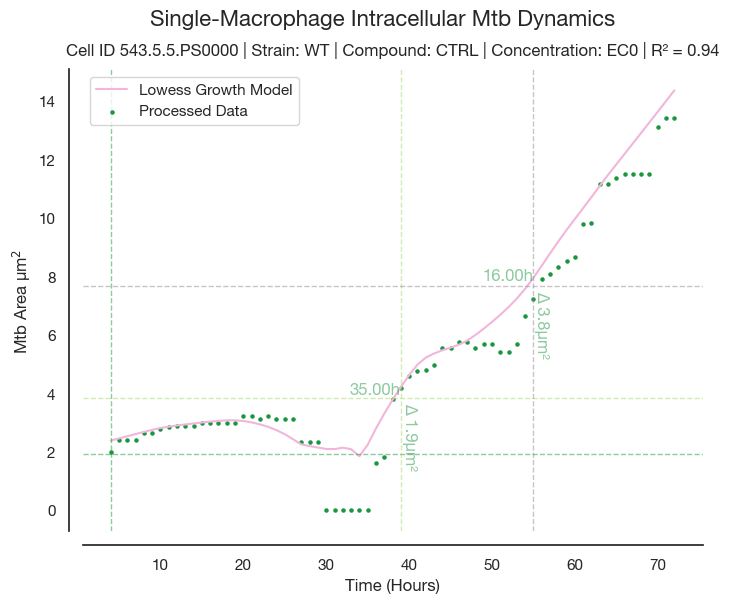

In [47]:
plot(ID, df)

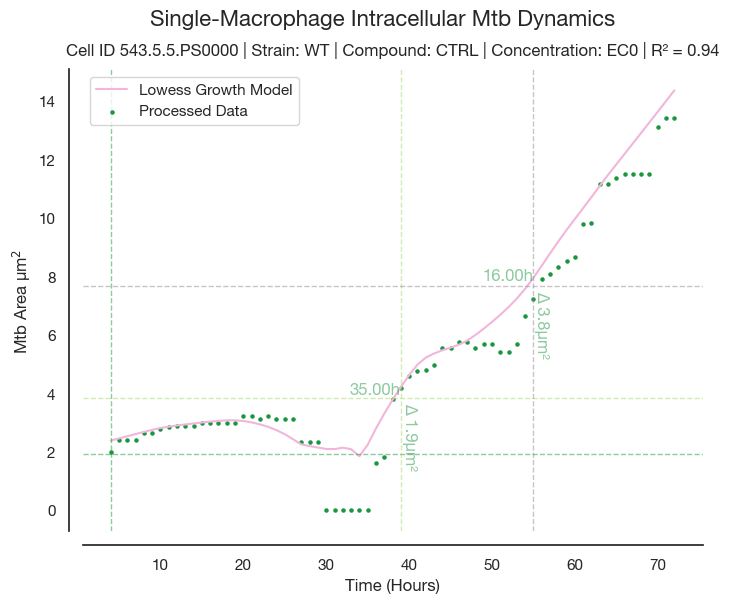

In [48]:
# Get single-cell trajectory in df format
sc_df = df[df['ID'] == ID]
# Drop NaN values specifically from the required columns
sc_df = sc_df.dropna(subset=['Time Model (hours)', 'Mtb Area Model (µm)', 'Mtb Area Processed (µm)'])
# Ensure there is temporal order
sc_df = sc_df.sort_values(by='Time Model (hours)')

# Extract Strain, Compound, and Concentration for the title
strain, compound, concentration = sc_df[['Strain', 'Compound', 'Concentration']].iloc[0].values

# Calculate the R2 value and skip plotting if R2 < 0.7
r2 = round(r2_score(sc_df['Mtb Area Processed (µm)'], sc_df['Mtb Area Model (µm)']), 2)
df.loc[df['ID'] == ID, 'r2'] = r2
if r2 < 0.7:
    # ill_fitting_curves[ID] = r2
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
    # df.loc[df['ID'] == ID, 'Doubling Times'] = None
    print(f'Nee fitting ({r2})')
    # return

# Find the temporal order of the minimum and maximum
min_value = max(sc_df['Mtb Area Model (µm)'].round(1).min(), 1.92) # has to be above the minimum threshold
max_value = sc_df['Mtb Area Model (µm)'].round(1).max()

# perform a check on the data
if max_value <= min_value:
    non_doubling_curves.append(ID)
    print(f'No population doubling for ID {ID}')

# Find the time indices of the minimum and maximum
min_index = sc_df['Mtb Area Model (µm)'].round(1).idxmin()
max_index = sc_df['Mtb Area Model (µm)'].round(1).idxmax()

# Check if maximum occurs before minimum
if max_index > min_index:
    growth = True
    # Minimum occurs before the maximum (indicating growth)
    # Start from the minimum and double
    N_i = min_value
    N_series = []
    
    # Generate the doubling series
    while N_i <= max_value:
        N_series.append(N_i)
        N_i *= 2
    
else:
    growth = False
    # non_doubling_curves.append(ID)
    print(f'No obvious growth for ID {ID}')
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
    # df.loc[df['ID'] == ID, 'Doubling Times'] = None
    # return
    # Maximum occurs before the minimum (indicating a reduction)
    # Start from the maximum and halve
    N_i = max_value
    N_series = []
    
    # Generate the halving series
    while N_i >= min_value:
        N_series.append(N_i)
        N_i /= 2

# Check if there are no valid doubling points
if len(N_series) < 2:
    non_doubling_curves.append(ID)
    print(f'No population doubling for ID {ID}')
    # df.loc[df['ID'] == ID, 'Doubling Amounts'] = None
    # df.loc[df['ID'] == ID, 'Doubling Times'] = None
    # return
    
# Find the indices and corresponding times for each doubling point
doubling_time_indices = np.clip(np.searchsorted(sc_df['Mtb Area Model (µm)'], N_series), 0, len(sc_df) - 1)
doubling_time_points = sc_df['Time Model (hours)'].iloc[doubling_time_indices]
doubling_times = doubling_time_points.diff().dropna().values.tolist()

# if not growth:
#     doubling_times = [-t for t in doubling_times]
#     N_series = [-n for n in N_series]  

# Incorporate N_series and doubling_times into the main DataFrame
# Assign lists to all entries in df with the same ID
# df.loc[df['ID'] == ID, 'Doubling Amounts'] = df.loc[df['ID'] == ID].apply(lambda x: N_series, axis=1)
# df.loc[df['ID'] == ID, 'Doubling Times'] = df.loc[df['ID'] == ID].apply(lambda x: doubling_times, axis=1)
# # df.to_pickle('/mnt/SYNO/macrohet_syno/results/dfs/dt_df_v2.pkl')
    
# Plot the experimental data and the fitted model
plt.figure(figsize=(8, 6))
plt.plot(sc_df['Time Model (hours)'], sc_df['Mtb Area Model (µm)'], label='Lowess Growth Model', color=colours[-2])
plt.scatter(sc_df['Time Model (hours)'], sc_df['Mtb Area Processed (µm)'], label='Processed Data', color=colours[0], s=5)

# Annotate doubling times and draw faint lines
for i, (time, population) in enumerate(zip(doubling_time_points, N_series)):
    time = abs(time)
    population = abs(population)
    color_index = i % len(expanded_piyg)  # This ensures the color index wraps around
    # Draw faint vertical lines at doubling time points
    plt.axvline(x=time, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    plt.axhline(y=population, color=expanded_piyg[color_index], linestyle='--', linewidth=1, alpha=0.5)
    
    # Place a text label indicating the doubling time
    if i > 0:  # Start labeling from the second point
        previous_time = doubling_time_points.iloc[i-1]
        
        # Midpoint between the two lines
        label_x_pos = time  # Correct the label position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population + (population * 0.01)  # Slightly above the horizontal line

        # Calculate the gap between the lines and scale the font size
        gap = time - previous_time
        scaled_fontsize = max(8, min(12, gap))  # Scale font size within a reasonable range (e.g., 8 to 12)
        
        # Draw the horizontal doubling time label
        plt.text(label_x_pos, label_y_pos, f'{abs(doubling_times[i-1]):.2f}h', 
                 ha='right', va='bottom', alpha=0.5, fontsize=scaled_fontsize, color=expanded_piyg[0])
        
        # Draw vertical arrow showing the change in N_series (doubling amount)
        deltaMtb = population - N_series[i-1]
        
        # Midpoint for the vertical delta annotation
        text_y_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population
        text_x_pos = (population + N_series[i-1]) / 2  # Midway between current and previous population

        # Midpoint between the two lines
        label_x_pos = time + 0.1  # Adjust x-position
        # Adjust y-position to place the label just above the horizontal line
        label_y_pos = population - (max_value * 0.01)
        
        # Place the vertical label using plt.text
        plt.text(label_x_pos, label_y_pos, f'Δ {abs(deltaMtb):.1f}µm²',
                 fontsize=scaled_fontsize, color=expanded_piyg[0], ha='left', va='top', rotation=270, alpha=0.5)

# Add labels, legend, and titles
plt.xlabel('Time (Hours)')
plt.ylabel('Mtb Area µm$^{2}$')
plt.legend()
    # Main title
plt.suptitle('Single-Macrophage Intracellular Mtb Dynamics', 
             weight='bold', fontsize=16)
# Subtitle
plt.title(f'Cell ID {ID} | Strain: {strain} | Compound: {compound} | Concentration: {concentration} | R² = {r2}', fontsize=12, pad=10)

sns.despine(offset=10)
plt.grid(False)

plt.show()

In [49]:
doubling_times

[35.0, 16.0]